In [70]:
import os
import sys
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../../")
from src.filepath import ABSOLUTE_PATH
from src.train.heatpipe import load_data, renormalize
from src.model.transolver import Transolver
from src.model.GeoFNO import GeoFNO2d as FNO
from src.utils.utils import relative_error, to_np, plot_scatter_compare, find_max_min
from src.model.diffusion import GaussianDiffusion
from src.inference.compose import compose_diffusion_multiE, compose_diffusion_multiE_ddim

In [71]:
device = "cuda"
diffusion_step = 250
model_type = "transformer"
ddim = True
ddim_step = 50 if ddim else diffusion_step
eta = 1
train_loader, test_loader = load_data(ABSOLUTE_PATH, 64, 14000, model_type=model_type, device=device)
del train_loader

In [72]:
if model_type == "transformer":
    model = Transolver(
        space_dim=2,
        n_layers=5,
        n_hidden=64,
        dropout=0.0,
        n_head=8,
        Time_Input=True,
        act="gelu",
        mlp_ratio=1,
        fun_dim=13,
        out_dim=3,
        slice_num=16,
        ref=8,
        unified_pos=False,
    ).to(device)
elif model_type == "FNO":
    modes = [8, 8, 8]
    model = FNO(
        modes1=modes[0], modes2=modes[1], modes3=modes[2], width=32, in_channels=13, out_channels=3, time_input=True
    ).to(device)


diffusion = GaussianDiffusion(
    model,
    seq_length=tuple([804, 3]),
    timesteps=diffusion_step,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
    ddim_sampling_eta=eta,
).to(device)


diffusion.load_state_dict(torch.load("../../results/heatpipe/diffusion/" + model_type + "/model.pt")["model"])

C:\Users\taozhan\AppData\Local\Temp\ipykernel_6016\4286652307.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion.load_state_dict(torch.load("../../results/heatpi

<All keys matched successfully>

### VAL

In [73]:
mae_n_T = 0
mae_T = 0
rmae_T = 0
mae_n_s = 0
mae_s = 0
rmae_s = 0
with torch.no_grad():
    for batch in test_loader:
        coord, fx, y = batch
        batchsize = y.shape[0]

        data_pred_n = diffusion.sample(batchsize, (coord, fx))
        data_pred = renormalize(data_pred_n)
        data_true_n = y
        data_true = renormalize(y)

        mae_n_T += torch.mean(torch.abs(data_true_n[..., 0:1] - data_pred_n[..., 0:1]))
        mae_T += torch.mean(torch.abs(data_true[..., 0:1] - data_pred[..., 0:1]))
        rmae_T += relative_error(data_true[..., 0:1], data_pred[..., 0:1])
        mae_n_s += torch.mean(torch.abs(data_true_n[..., 1:] - data_pred_n[..., 1:]))
        mae_s += torch.mean(torch.abs(data_true[..., 1:] - data_pred[..., 1:]))
        rmae_s += relative_error(data_true[..., 1:], data_pred[..., 1:])
mae_n_T, mae_T, rmae_T = mae_n_T / len(test_loader), mae_T / len(test_loader), rmae_T / len(test_loader)
mae_n_s, mae_s, rmae_s = mae_n_s / len(test_loader), mae_s / len(test_loader), rmae_s / len(test_loader)
mae_n_T, mae_T, rmae_T, mae_n_s, mae_s, rmae_s

sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 56.49it/s]


(tensor(0.0038, device='cuda:0'),
 tensor(1.0384, device='cuda:0'),
 0.0013033629627898335,
 tensor(0.0048, device='cuda:0'),
 tensor(1.0065e-05, device='cuda:0'),
 0.003221867675893009)

In [74]:
batch_n = np.random.randint(0, data_pred.shape[0])
phy_tag = np.random.randint(0, 3)
coord_x = to_np(coord[batch_n, :, 0])
coord_y = to_np(coord[batch_n, :, 1])
data_pred_np = to_np(data_pred[batch_n, :, phy_tag])
data_true_np = to_np(data_true[batch_n, :, phy_tag])

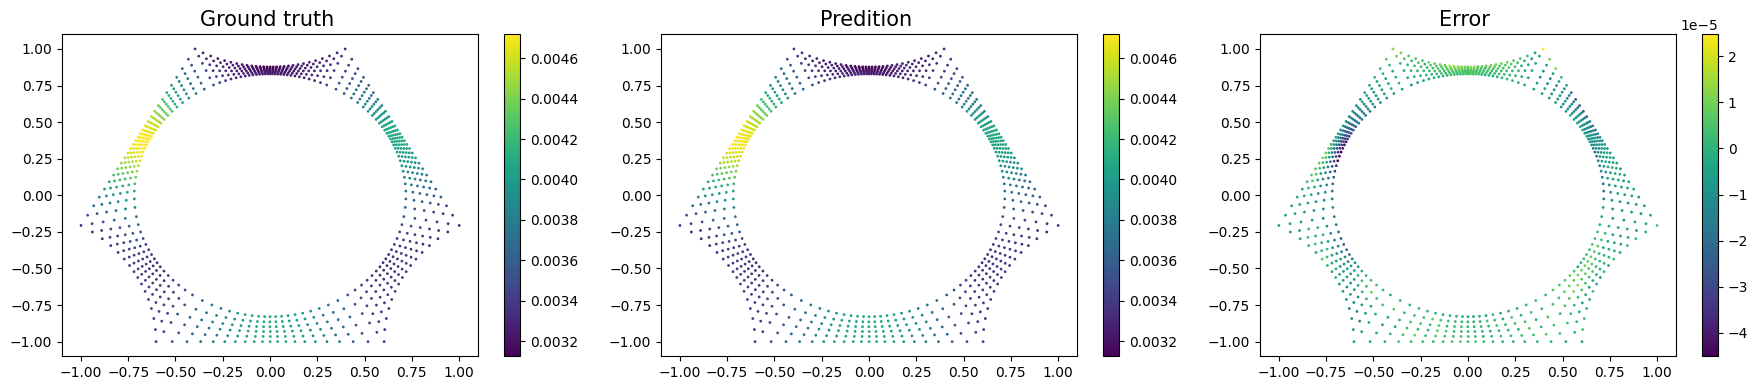

In [75]:
plot_scatter_compare(coord_x, coord_y, data_true_np, data_pred_np)

val in 16 elements

In [76]:
# x = np.load("../../data/heatpipe/x.npy").reshape(-1, 16, 804, 10)
# y = np.load("../../data/heatpipe/y.npy").reshape(-1, 16, 804, 3)
# n_batch = 0  # np.random.randint(0, 1000)
# x = torch.tensor(x[n_batch]).to(device).float()
# data_true = torch.tensor(y[batch_n]).to(device).float()
x = torch.tensor(np.load("../../data/heatpipe/x.npy")[:16]).to(device).float()
y = torch.tensor(np.load("../../data/heatpipe/y.npy")[:16]).to(device).float()
data_true = to_np(renormalize(y))
if model_type == "FNO":
    coord = torch.zeros(x.shape[1], 3).to(device)
    coordxy = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coordxy[:, 0] = (coordxy[:, 0] - 0.0455) / (0.065345 - 0.0455)
    coordxy[:, 1] = (coordxy[:, 1] - 0.072) / (0.08918 - 0.072)
    coord[:, :-1] = coordxy
    coord = coord.expand(x.shape[0], -1, -1)
else:
    coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
    coord = coord.expand(x.shape[0], -1, -1)
y_p = to_np(renormalize(diffusion.sample(y.shape[0], (coord, x))))
coord.shape, data_true.shape, x.shape, data_true.shape, y_p.shape

sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 198.71it/s]


(torch.Size([16, 804, 2]),
 (16, 804, 3),
 torch.Size([16, 804, 10]),
 (16, 804, 3),
 (16, 804, 3))

In [77]:
relative_error(data_true[..., 0], y_p[..., 0]), relative_error(data_true[..., 1:], y_p[..., 1:])

(0.001173871336504817, 0.00340680917724967)

In [78]:
bc1 = np.load("../../data/heatpipe/1/bc.npy")
bc2 = np.load("../../data/heatpipe/2/bc.npy")
bc = np.concatenate((bc1, bc2), axis=0)
x = np.load("../../data/heatpipe/x.npy").reshape(-1, 16, 804, 10)
y = np.load("../../data/heatpipe/y.npy").reshape(-1, 16, 804, 3)

batch_n = 903  # np.random.randint(0, 1000)
x = torch.tensor(x[batch_n]).to(device).float()
flux = x[:, -1, -1]
data_true = torch.tensor(y[batch_n]).to(device).float()
data_true = to_np(renormalize(data_true))
data_true.shape, x.shape, data_true.shape, bc[batch_n], batch_n

((16, 804, 3),
 torch.Size([16, 804, 10]),
 (16, 804, 3),
 array([[0, 1, 1],
        [0, 0, 0],
        [0, 1, 1]], dtype=int64),
 903)

In [79]:
def update(
    alpha,
    neighbors,
    cond_shape,
    boundary_emb,
    mult_e_estimate,
    mult_e_estimate_before,
    other_condition,
    normalize=nn.Identity(),
    renormalize=nn.Identity(),
):
    # boundary in neighbors should corrspond with boundary
    device = mult_e_estimate.device
    n_element, n_node = mult_e_estimate.shape[0], mult_e_estimate.shape[1]
    channel = mult_e_estimate.shape[-1]
    node_feature = torch.zeros((n_element, n_node) + (cond_shape,)).to(device)
    coord = other_condition[0]
    flux = other_condition[1]

    weight_field = mult_e_estimate_before * (1 - alpha) + mult_e_estimate * alpha

    for i in range(n_element):
        for j, neighbor in enumerate(neighbors[i + 1]):
            if not isinstance(neighbor, int):
                b_emb = torch.tensor(boundary_emb(neighbor)).to(device)
                node_feature[i, :, j * channel : j * channel + channel] = b_emb
            else:
                node_feature[i, :, j * channel : j * channel + channel] = weight_field[neighbor - 1]
        node_feature[i, :, (j + 1) * channel :] = flux[i]
    return (coord, node_feature)

In [80]:
def boundary_emb_f(b_type, n_nods=804):
    free_emb = np.array([0, 0, 0])  # np.ones((1, 8)) * -1
    sym_emb = np.array([0, 1, 1])  # np.ones((1, 8)) * -2
    if b_type == "sym":
        return np.tile(sym_emb, (n_nods, 1))
    elif b_type == "free":
        return np.tile(free_emb, (n_nods, 1))

In [81]:
def coord_transform(coord):

    move_dis = 1 * np.array(
        [
            [0, 0],
            [-0.013856407, -0.024],
            [0.013856406, -0.024],
            [-0.027712807, -0.048],
            [0.0, -0.048],
            [0.027712813, -0.048],
            [-0.041569220, -0.072],
            [-0.013856407, -0.072],
            [0.013856406, -0.0720],
            [0.0415692190, -0.072],
            [0, 0],
            [-0.013856407, -0.024],
            [0.013856406, -0.024],
            [-0.027712807, -0.048],
            [0.0, -0.048],
            [0.027712813, -0.048],
        ]
    )

    sym = [-1] * 10 + [0.072, 0.072, 0.072, 0.072, 0.072, 0.072]

    def sym_block(y_coords, sym_axis):
        if sym_axis < 0:
            return y_coords
        else:
            sym_y_coords = 2 * sym_axis - y_coords
            return sym_y_coords

    coord_new = torch.zeros_like(coord)
    if model_type == "FNO":
        coord_new[:, :, 0] = (coord[:, :, 0]) * (0.065345 - 0.0455) + 0.0455
        coord_new[:, :, 1] = (coord[:, :, 1]) * (0.08918 - 0.072) + 0.072
    else:
        coord_new[:, :, 0] = (coord[:, :, 0] + 1) / 2 * (0.065345 - 0.0455) + 0.0455
        coord_new[:, :, 1] = (coord[:, :, 1] + 1) / 2 * (0.08918 - 0.072) + 0.072
    for i in range(move_dis.shape[0]):
        coord_new[i, :, 0] = coord_new[i, :, 0] + move_dis[i][0]
        coord_new[i, :, 1] = sym_block(coord_new[i, :, 1], sym[i])
        coord_new[i, :, 1] = coord_new[i, :, 1] + move_dis[i][1]
    # coord_new = to_np(coord_new.reshape(-1, 2))
    # coord_new_x = coord_new[:, 0]
    # coord_new_y = coord_new[:, 1]
    return coord_new

In [82]:
left = "free" if all(x == y for x, y in zip(bc[batch_n, 0], [0, 0, 0])) else "sym"
right = "free" if all(x == y for x, y in zip(bc[batch_n, 1], [0, 0, 0])) else "sym"
bottom = "free" if all(x == y for x, y in zip(bc[batch_n, 2], [0, 0, 0])) else "sym"
# left = "free"
# right = "free"
# bottom = (renomalize_disp(-0.0832), renomalize_disp(-0.2587))  # "fix"
neighbors = {
    1: (left, right, 11),
    2: (left, 11, 12),
    3: (11, right, 13),
    4: (left, 12, 14),
    5: (12, 13, 15),
    6: (13, right, 16),
    7: (left, 14, bottom),
    8: (14, 15, bottom),
    9: (15, 16, bottom),
    10: (16, right, bottom),
    11: (3, 2, 1),
    12: (5, 4, 2),
    13: (6, 5, 3),
    14: (8, 7, 4),
    15: (9, 8, 5),
    16: (10, 9, 6),
}
left, right, bottom

('sym', 'free', 'sym')

validation data

In [83]:
if not ddim:
    mult_e = compose_diffusion_multiE(
        model=diffusion,
        shape=(804, 3),
        cond_shape=10,
        update_f=update,
        adj=neighbors,
        boundary_emb=boundary_emb_f,
        other_condition=[coord, flux],
        num_iter=3,
    )
else:
    mult_e = compose_diffusion_multiE_ddim(
        model=diffusion,
        shape=(804, 3),
        cond_shape=10,
        update_f=update,
        adj=neighbors,
        boundary_emb=boundary_emb_f,
        other_condition=[coord, flux],
        num_iter=3,
    )
mult_e.shape, data_true.shape

sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 154.76it/s]


(torch.Size([16, 804, 3]), (16, 804, 3))

In [84]:
data_pred = to_np(renormalize(mult_e))
data_pred.shape

(16, 804, 3)

In [85]:
relative_error(data_true[..., :1], data_pred[..., :1]), relative_error(data_true[..., 1:], data_pred[..., 1:])

(0.009146025404334068, 0.02063564583659172)

In [86]:
relative_error(data_true.reshape(-1, 3)[..., :1], data_pred.reshape(-1, 3)[..., :1]), relative_error(
    data_true[..., 1:].reshape(-1, 3), data_pred[..., 1:].reshape(-1, 3)
)

(0.005537214563853705, 0.01620455642244709)

In [87]:
coord_new = coord_transform(coord)
coord_new = to_np(coord_new.reshape(-1, 2))
coord_new_x = coord_new[:, 0]
coord_new_y = coord_new[:, 1]

### T

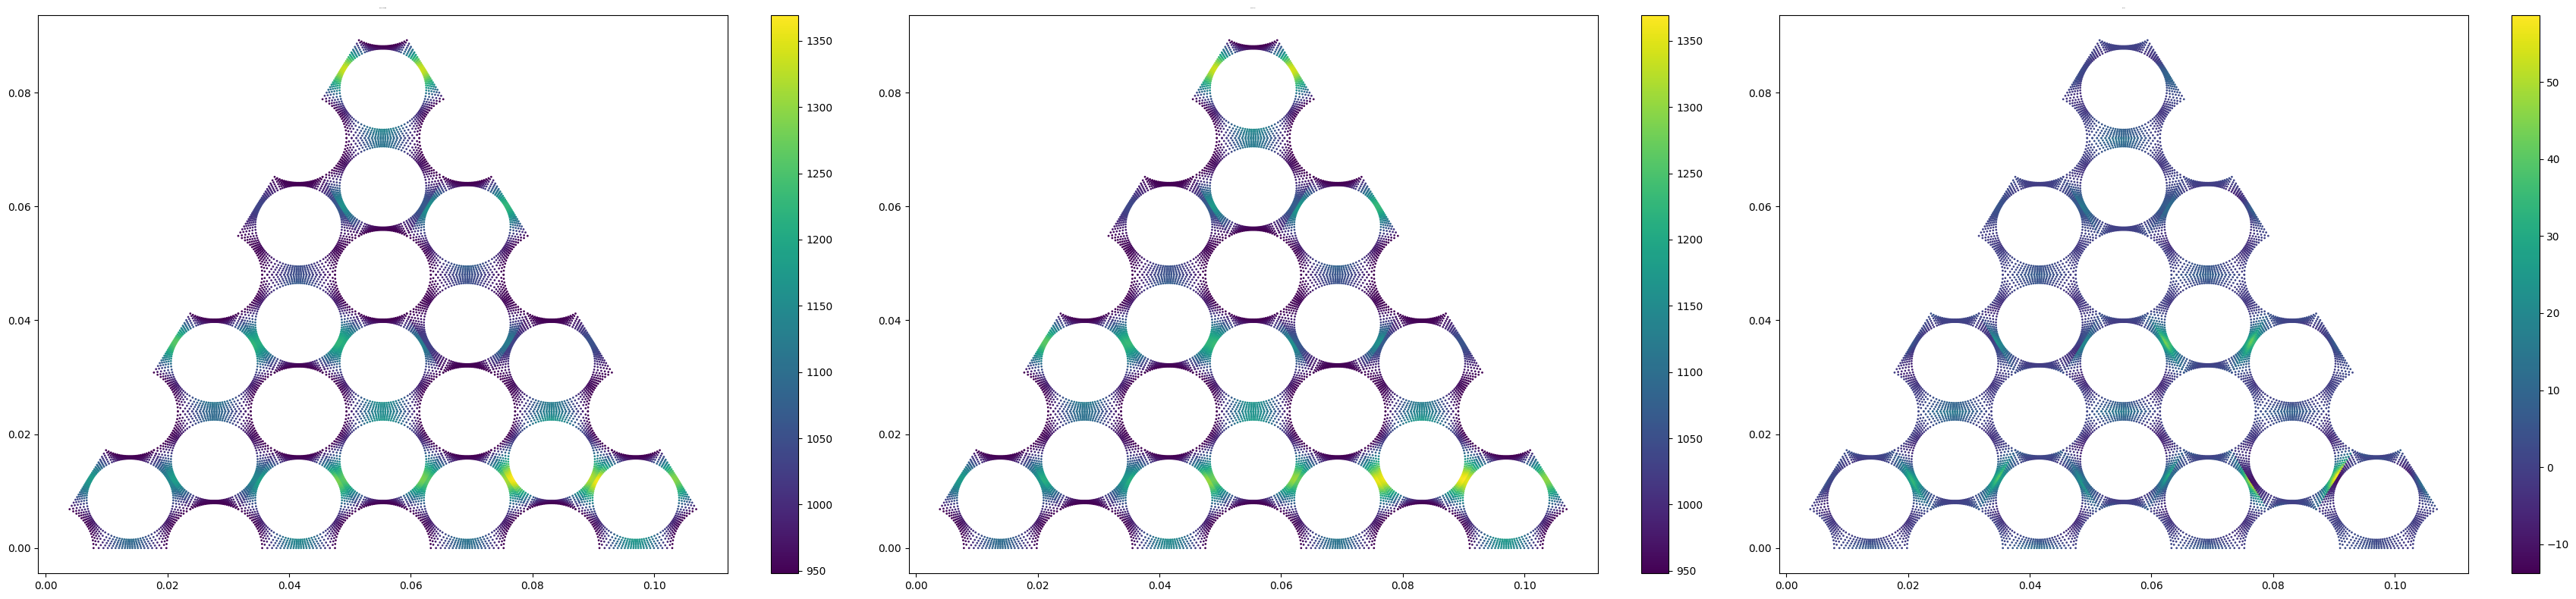

In [88]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 0].reshape(-1),
    to_np(data_pred)[..., 0].reshape(-1),
    figsize=(35, 8),
    fontsize=0.1,
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/T.pdf",
)

### disp_x

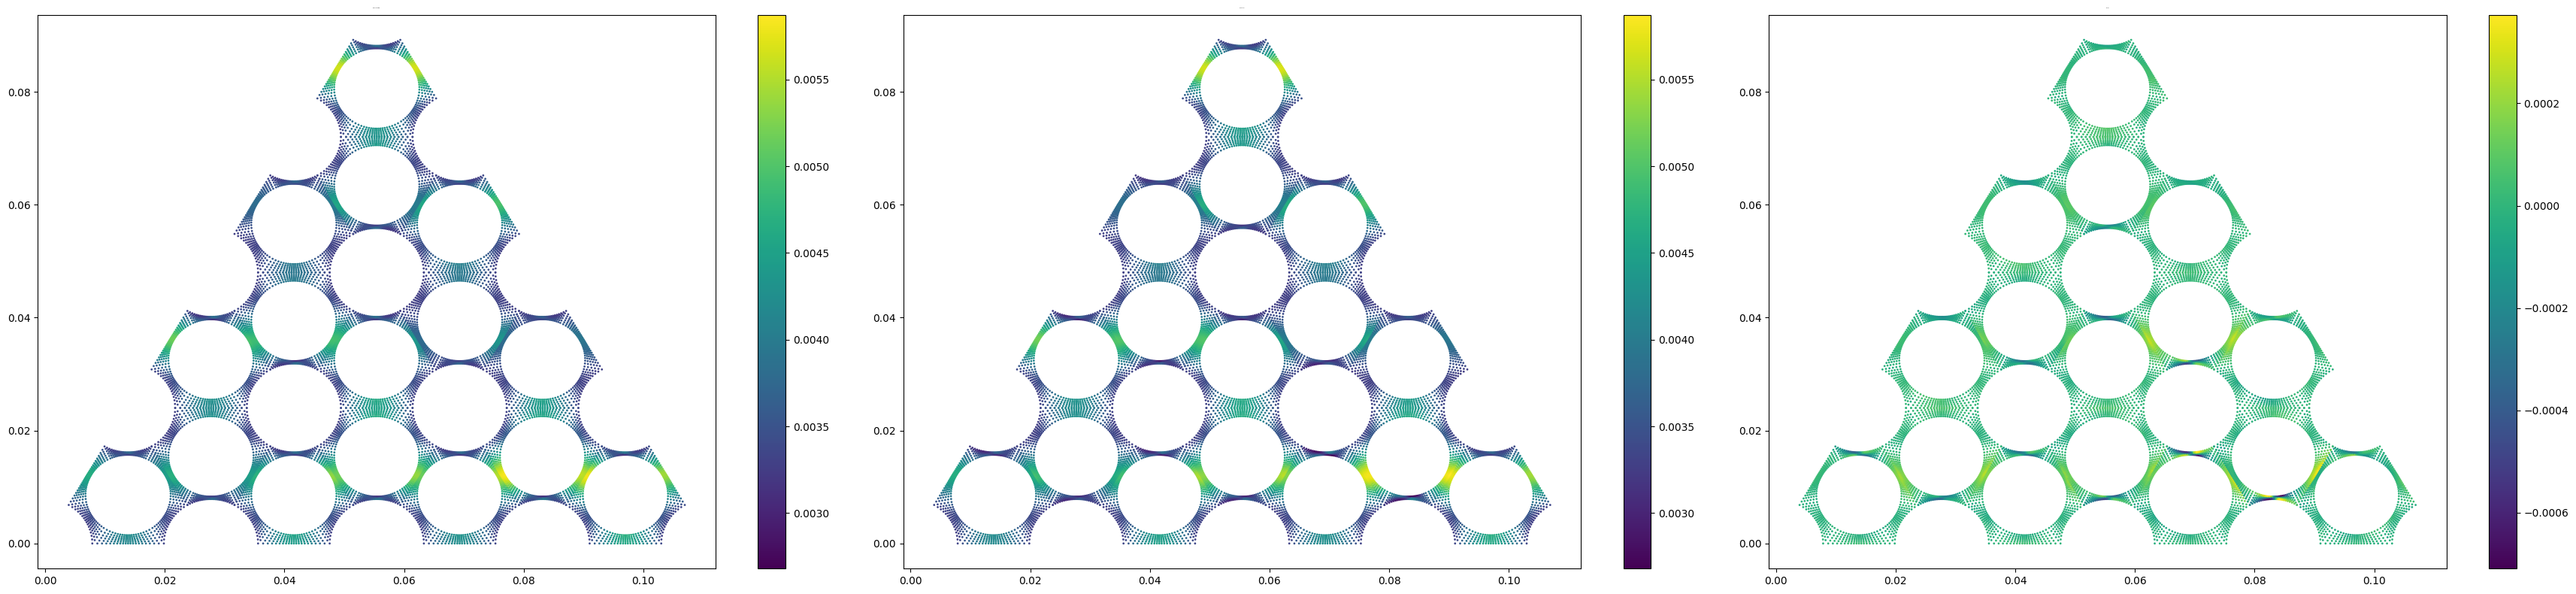

In [89]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 1].reshape(-1),
    to_np(data_pred)[..., 1].reshape(-1),
    figsize=(35, 8),
    fontsize=0.1,
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/strainx.pdf",
)

### disp_y

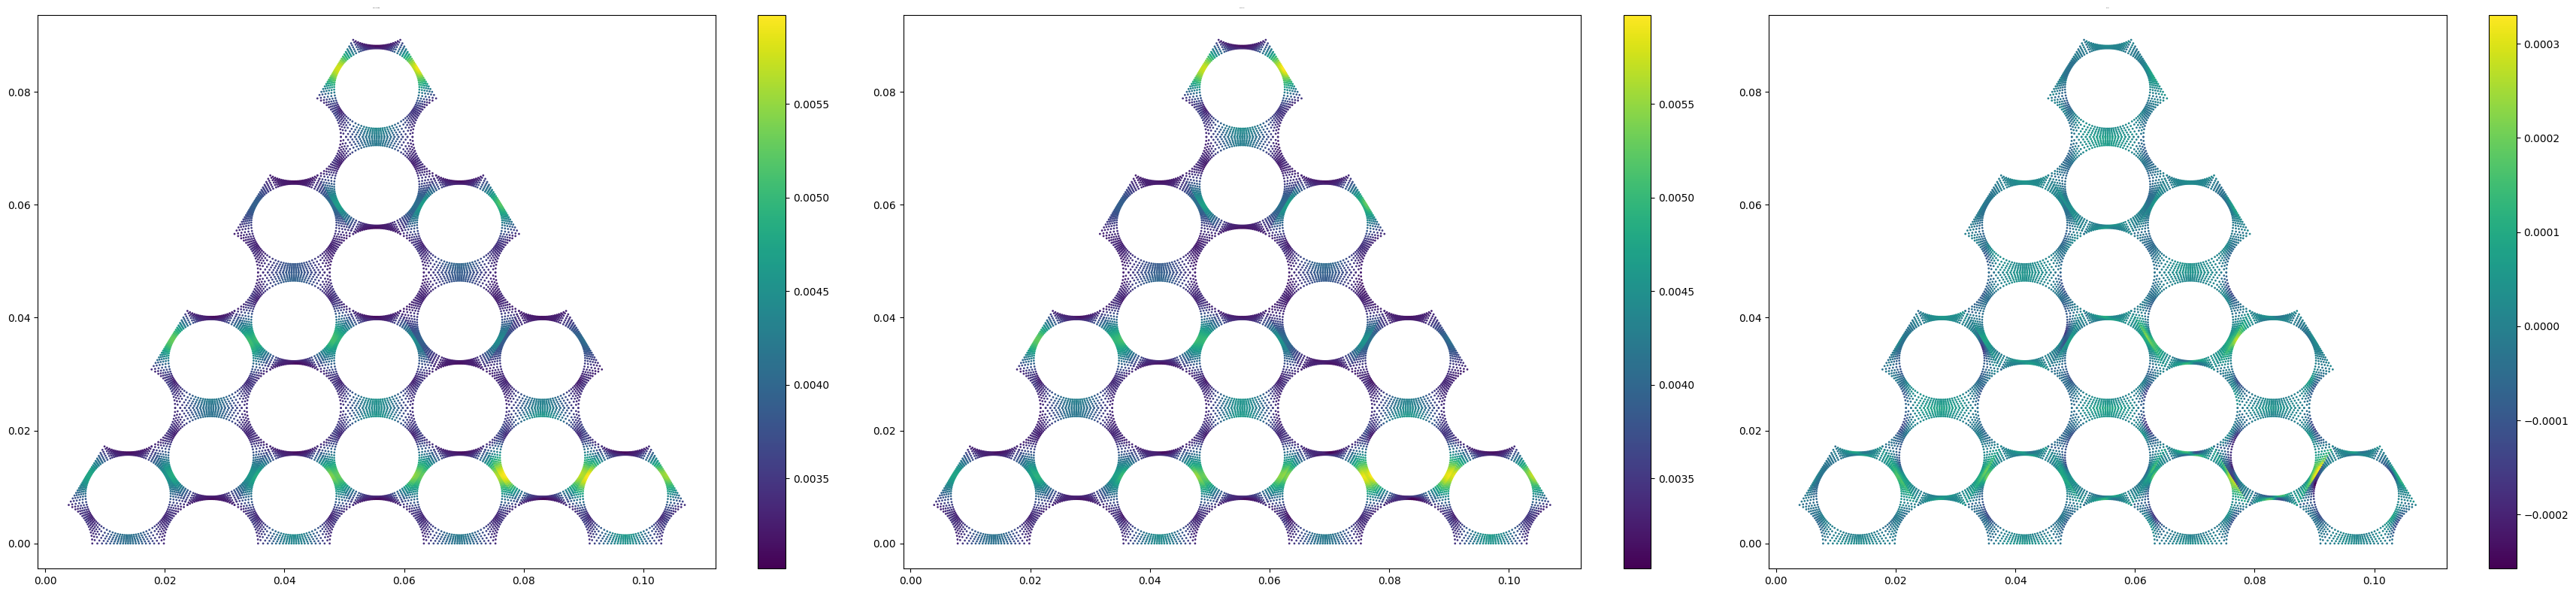

In [90]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 2].reshape(-1),
    to_np(data_pred)[..., 2].reshape(-1),
    figsize=(35, 8),
    fontsize=0.1,
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/strainy.pdf",
)

In [91]:
left = "sym"
right = "free"
bottom = "sym"
# left = "free"
# right = "free"
# bottom = (renomalize_disp(-0.0832), renomalize_disp(-0.2587))  # "fix"
neighbors = {
    # 1
    1: (left, right, 11),
    2: (left, 11, 12),
    3: (11, right, 13),
    4: (left, 12, 14),
    5: (12, 13, 15),
    6: (13, right, 16),
    7: (left, 14, 26),
    8: (14, 15, 25),
    9: (15, 16, 24),
    10: (16, right, 23),
    11: (3, 2, 1),
    12: (5, 4, 2),
    13: (6, 5, 3),
    14: (8, 7, 4),
    15: (9, 8, 5),
    16: (10, 9, 6),
    17: (55, 42, 27),
    18: (52, 27, 28),
    19: (27, 38, 29),
    20: (50, 28, 30),
    21: (28, 29, 31),
    22: (29, 35, 32),
    23: (49, 30, 10),
    24: (30, 31, 9),
    25: (31, 32, 8),
    26: (32, 33, 7),
    27: (19, 18, 17),
    28: (21, 20, 18),
    29: (22, 21, 19),
    30: (24, 23, 20),
    31: (25, 24, 21),
    32: (26, 25, 22),
    33: (left, 26, 43),
    34: (left, 43, 44),
    35: (43, 22, 45),
    36: (left, 44, 46),
    37: (44, 45, 47),
    38: (45, 19, 48),
    39: (left, 46, bottom),
    40: (46, 47, bottom),
    41: (47, 48, bottom),
    42: (48, 17, bottom),
    43: (35, 34, 33),
    44: (37, 36, 34),
    45: (38, 37, 35),
    46: (40, 39, 36),
    47: (41, 40, 37),
    48: (42, 41, 38),
    49: (23, right, 59),
    50: (20, 59, 60),
    51: (59, right, 61),
    52: (18, 60, 62),
    53: (60, 61, 63),
    54: (61, right, 64),
    55: (17, 62, bottom),
    56: (62, 63, bottom),
    57: (63, 64, bottom),
    58: (64, right, bottom),
    59: (51, 50, 49),
    60: (53, 52, 50),
    61: (54, 53, 51),
    62: (56, 55, 52),
    63: (57, 56, 53),
    64: (58, 57, 54),
}

In [92]:
if model_type == "FNO":
    coord = torch.zeros(804, 3).to(device)
    coordxy = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coordxy[:, 0] = (coordxy[:, 0] - 0.0455) / (0.065345 - 0.0455)
    coordxy[:, 1] = (coordxy[:, 1] - 0.072) / (0.08918 - 0.072)
    coord[:, :-1] = coordxy
    coord = coord.expand(64, -1, -1)
else:
    coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
    coord = coord.expand(64, -1, -1)
flux = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/val_flux.npy")).to(device)
flux = (flux - 1e5) / 9e5 * 2 - 1
coord.shape, flux.shape

(torch.Size([64, 804, 2]), torch.Size([64]))

In [93]:
if not ddim:
    mult_e = compose_diffusion_multiE(
        model=diffusion,
        shape=(804, 3),
        cond_shape=10,
        update_f=update,
        adj=neighbors,
        boundary_emb=boundary_emb_f,
        other_condition=[coord, flux],
        num_iter=2,
    )
else:
    mult_e = compose_diffusion_multiE_ddim(
        model=diffusion,
        shape=(804, 3),
        cond_shape=10,
        update_f=update,
        adj=neighbors,
        boundary_emb=boundary_emb_f,
        other_condition=[coord, flux],
        num_iter=3,
    )

sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 40.66it/s]


In [94]:
def coord_transform2(coord):
    base_coord = coord

    coord1 = np.zeros_like(base_coord)
    coord1[..., 0] = 2 * 0.0554256215 - base_coord[..., 0]
    coord1[..., 1] = -base_coord[..., 1]

    coord2 = np.zeros_like(base_coord)
    coord2[..., 0] = base_coord[..., 0] - 0.055425618
    coord2[..., 1] = base_coord[..., 1] - 0.096

    coord3 = np.zeros_like(base_coord)
    coord3[..., 0] = base_coord[..., 0] + 0.055425618
    coord3[..., 1] = base_coord[..., 1] - 0.096
    return np.concatenate((base_coord, coord1, coord2, coord3), axis=0)

In [95]:
mult_e = to_np(renormalize(mult_e))

In [96]:
coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
if model_type == "FNO":
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455)
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072)
else:
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
coord = coord.expand(16, -1, -1)

coord = to_np(coord_transform(coord))
coord.shape

(16, 804, 2)

In [97]:
coord_val = np.load(ABSOLUTE_PATH + "/data/heatpipe/coord_val.npy")
val_y = np.load(ABSOLUTE_PATH + "/data/heatpipe/val_y.npy")
bound = [[948, 1500], [-4e-4, 1.2e-3], [-4e-4, 1.2e-3]]
val_y = renormalize(val_y)
# for i in range(3):
#     val_y[..., i] = (val_y[..., i] - bound[i][0]) / (bound[i][1] - bound[i][0])

In [98]:
val_y.shape, mult_e.shape

((51456, 3), (64, 804, 3))

In [99]:
tolerance = 5e-5
coord_struture_big = coord_transform2(to_np(coord))
x_new, y_new = coord_struture_big[..., 0].reshape(-1), coord_struture_big[..., 1].reshape(-1)
val_y_sorted = np.empty_like(val_y)
for i, (x_val, y_val) in enumerate(zip(x_new, y_new)):
    distances = np.sqrt((coord_val[:, 0] - x_val) ** 2 + (coord_val[:, 1] - y_val) ** 2)
    min_distance_index = np.argmin(distances)
    val_y_sorted[i] = val_y[min_distance_index]
    if distances[min_distance_index] > tolerance:
        print(
            f"Multiple matching coordinates found for ({i},{x_val}, {y_val}) within tolerance, the min distance is {distances[min_distance_index]}."
        )

In [100]:
mult_e = mult_e.reshape(-1, 3)
relative_error(mult_e[..., :1], val_y_sorted[..., :1]), relative_error(mult_e[..., 1:], val_y_sorted[..., 1:])

(0.010486633431644203, 0.027956696422229765)

compose iter 1: 0.009071380143288493, 0.023575432065924926  
compose iter 2: 0.008330713585394393, 0.022211745967903464  
compose iter 3: 0.007845908769075104, 0.020640788315183692   
compose iter 4: 0.007722183197888098, 0.020671428361806608  
compose iter 5: 0.007497295786616642, 0.020333036594145933    

In [49]:
mult_e = mult_e.reshape(-1, 3)

In [50]:
def plot_scatter_compare(
    coord_x,
    coord_y,
    true_d,
    pred_d,
    pointsize=1,
    figsize=(18, 4),
    savep=None,
    fontsize=15,
    cmap="viridis",
    paraname="",
    Unit_="",
    language="eng",
    e_min=None,
    e_max=None,
):
    # compare
    # shape: w*h
    if torch.is_tensor(true_d):
        if true_d.is_cuda:
            true_d = true_d.cpu()
            pred_d = pred_d.cpu()
        true_d = true_d.numpy()
        pred_d = pred_d.numpy()
    title_list = ["Ground truth ", "Predition ", "Error "]

    vmin = min(np.min(true_d), np.min(pred_d))
    vmax = max(np.max(true_d), np.max(pred_d))

    Unit1 = ""
    if len(Unit_) > 0:
        Unit1 = "(" + Unit_ + ")"
    plt.figure(figsize=figsize)
    plt.subplot(311)
    sc1 = plt.scatter(coord_x, coord_y, c=true_d, cmap=cmap, edgecolors=None, s=pointsize, vmin=vmin, vmax=vmax)
    plt.title(title_list[0] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc1)

    plt.subplot(312)
    sc2 = plt.scatter(coord_x, coord_y, c=pred_d, cmap=cmap, edgecolors=None, s=pointsize, vmin=vmin, vmax=vmax)
    plt.title(title_list[1] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc2)

    plt.subplot(313)
    if e_max is None or e_min is None:
        e_max, e_min = find_max_min(pred_d - true_d)
    sc3 = plt.scatter(
        coord_x, coord_y, c=(pred_d - true_d), cmap=cmap, edgecolors=None, s=pointsize, vmin=e_min, vmax=e_max
    )
    plt.title(title_list[2] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc3)

    plt.tight_layout()
    if savep is not None:
        plt.savefig(savep)
    plt.show()

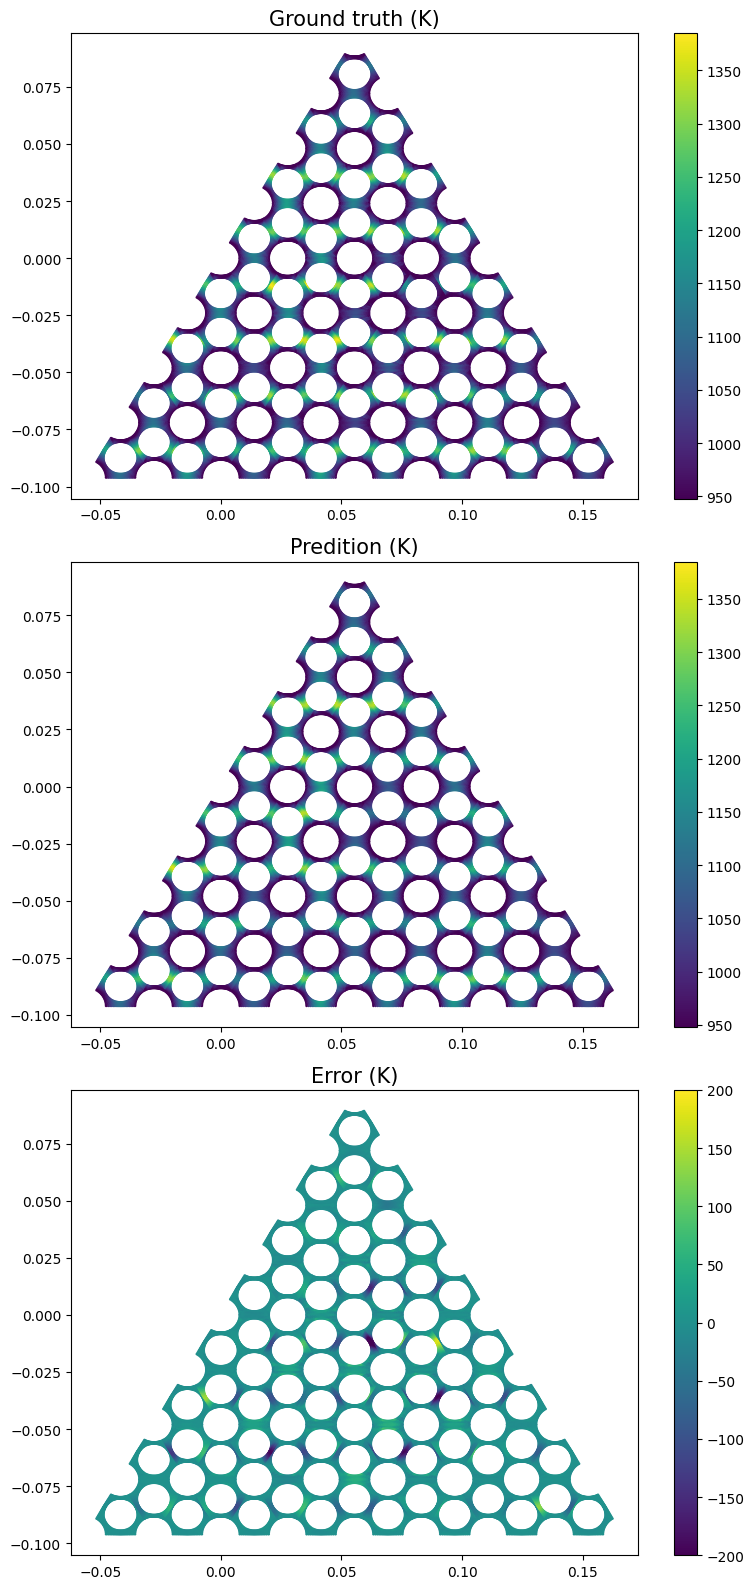

In [51]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 0],
    to_np(val_y_sorted)[:, 0],
    figsize=(8, 16),
    pointsize=1,
    fontsize=15,
    Unit_="K",
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/d_val_T.png",
    e_max=200,
    e_min=-200,
)

In [52]:
val_y.shape, mult_e.reshape(-1, 3).shape

((51456, 3), (51456, 3))

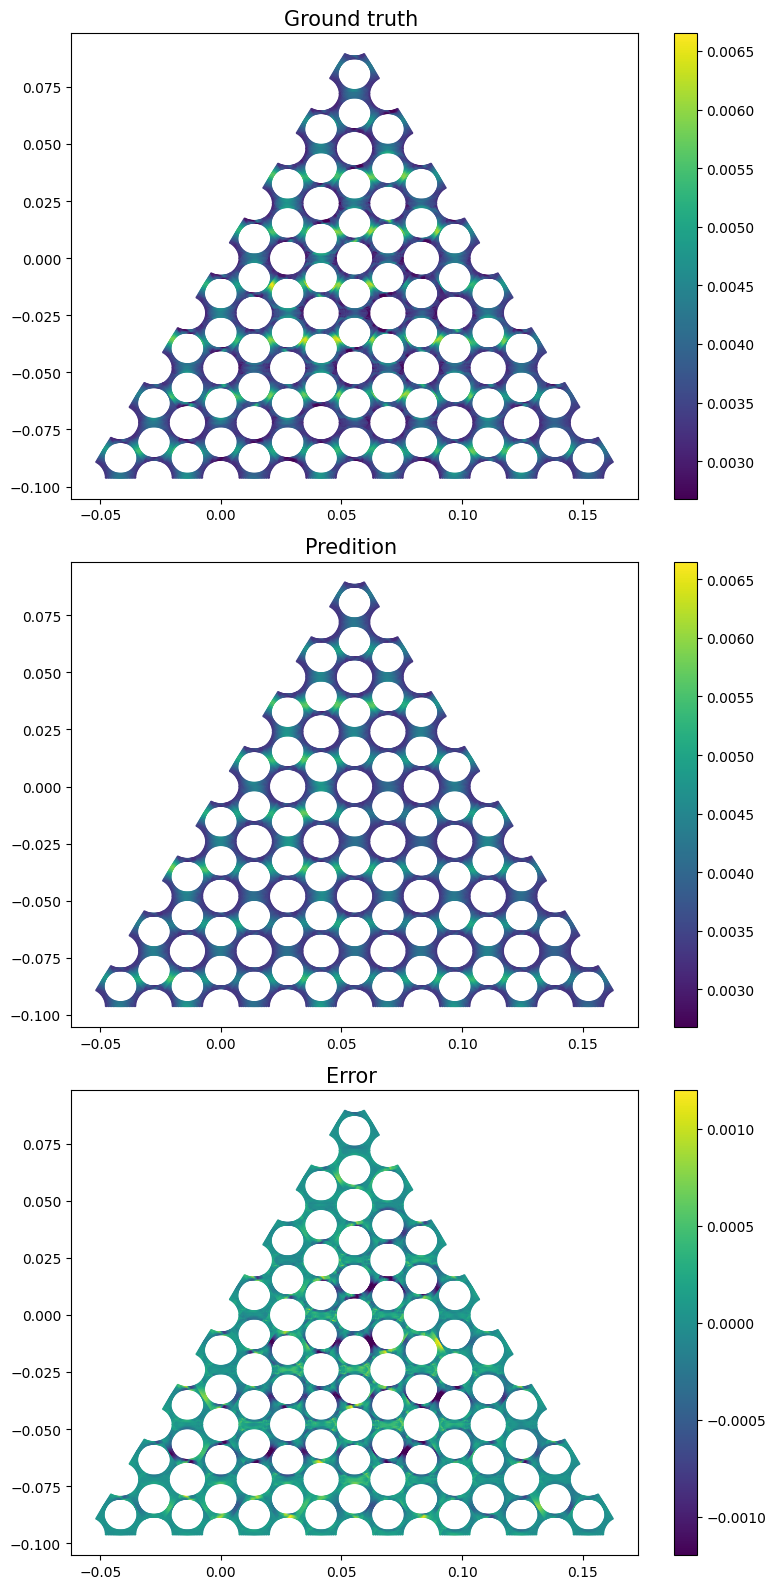

In [53]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 1],
    to_np(val_y_sorted)[:, 1],
    figsize=(8, 16),
    pointsize=1,
    fontsize=15,
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/d_val_sx.png",
    e_max=1.2e-3,
    e_min=-1.2e-3,
)

In [ ]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 2],
    to_np(val_y_sorted)[:, 2],
    figsize=(18, 4),
    pointsize=1,
    fontsize=15,
    savep=ABSOLUTE_PATH + "/results/heatpipe/diffusion/d_val_sy.png",
    e_max=1.2e-3,
    e_min=-1.2e-3,
)